In [1]:
!nvidia-smi

Fri Nov 29 11:03:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P3              N/A /  80W |      9MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from utils import *

from tqdm import tqdm,trange
import torchvision.utils as vutils
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

## DDPM Hyperparameters

In [3]:
# cosine schedule
from math import pi
T = 1000
angles = torch.linspace(0.1, pi-0.1, T)
alpha_bars = (1 + torch.cos(angles)) / 2
alphas = torch.ones_like(alpha_bars,dtype=torch.float)
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
sigmas = torch.sqrt(1-alphas)
alpha_bars[::100]

tensor([0.9975, 0.9616, 0.8860, 0.7771, 0.6444, 0.4993, 0.3542, 0.2217, 0.1131,
        0.0378])

# DDPM

In [4]:
class DDPM_BatchPrep(BatchPrepareBase):
    def __init__(self, max_T=500):
        super().__init__()
        self.max_T = max_T
        
    def process(self,x):
        ts = torch.randint(0, self.max_T, (x.shape[0],1,1,1))
        noise = torch.randn_like(x)
        inputs = torch.sqrt(alpha_bars[ts]) * x + torch.sqrt(1 - alpha_bars[ts]) * noise
        targets = noise
        return inputs, ts.reshape(-1), targets

In [5]:
class DDPM_Sampler(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        
    def calc(self,model,num):
        data = next(iter(test_loader))[0][:num].cuda()
        x = data * torch.sqrt(alpha_bars[self.max_T-1]) + torch.randn_like(data) * torch.sqrt(1-alpha_bars[self.max_T-1])
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/halfddpm_init.png')
        
        for t in trange(self.max_T-1,-1,-1):
            w1 = 1/torch.sqrt(alphas[t]).cuda()
            w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
            x = w1 * (x - w2 * model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
        
        return x

In [6]:
class DDPM_trainer(TrainerBase):
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            opt.param_groups[0]['lr'] = (1e-4 * (torch.cos(torch.tensor(epoch/self.epochs * pi))+1)/2).item()
            lr = opt.param_groups[0]['lr']
            self.model.train()
            train_losses = Avger()
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs,ts,targets = self.preparer.process(x)
                    pred = self.model(inputs,ts)
                    loss = F.mse_loss(pred,targets.cuda())
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_losses.append(loss.item())
                    bar.set_description(f'Epoch {epoch} (lr {lr:4f}) loss {train_losses}')
                    # break
            
            if epoch == 0 or (epoch+1) % self.sample_ep == 0 or epoch == self.epochs-1:
                self.model.eval()
                self.sampler.sample(self.model,num=64,desc=f'ep_{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [7]:
from vanilla_unet import UNet

## Full DDPM (Baseline)

In [8]:
assert False

AssertionError: 

In [8]:
model = UNet().cuda()
model = nn.DataParallel(model)
preparer = DDPM_BatchPrep(max_T=T)
sampler = DDPM_Sampler(max_T=T)
trainer = DDPM_trainer(model, preparer=preparer, sampler=sampler, epochs=50, lr=1e-4, sample_ep=4, desc='full_ddpm')
trainer.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.68it/s]


Epoch 1, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.55it/s]


Epoch 4, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.66it/s]


Epoch 8, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.67it/s]


Epoch 12, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.61it/s]


Epoch 16, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.59it/s]


Epoch 20, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.56it/s]


Epoch 24, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.56it/s]


Epoch 28, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.53it/s]


Epoch 32, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.54it/s]


Epoch 36, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.51it/s]


Epoch 40, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.60it/s]


Epoch 44, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.56it/s]


Epoch 48, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.64it/s]


Epoch 50, sample saved


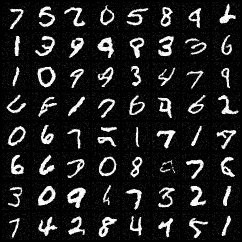

In [11]:
display(Image('samples/ep_50_full_ddpm.png'))

In [12]:
assert os.path.exists('checkpoints/ep_50_full_ddpm.pth')
!cp checkpoints/ep_50_full_ddpm.pth backup/ep_50_full_ddpm.pth

# Half DDPM

In [ ]:
assert False

In [13]:
model = UNet().cuda()
model = nn.DataParallel(model)
preparer = DDPM_BatchPrep(max_T=T//2)
sampler = DDPM_Sampler(max_T=T//2)
trainer = DDPM_trainer(model, preparer=preparer, sampler=sampler, epochs=50, lr=1e-4, sample_ep=4, desc='half_ddpm')
trainer.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.66it/s]


Epoch 1, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.46it/s]


Epoch 4, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.47it/s]


Epoch 8, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.45it/s]


Epoch 12, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.44it/s]


Epoch 16, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.82it/s]


Epoch 20, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.85it/s]


Epoch 24, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.09it/s]


Epoch 28, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.38it/s]


Epoch 32, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.39it/s]


Epoch 36, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.36it/s]


Epoch 40, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.39it/s]


Epoch 44, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.36it/s]


Epoch 48, sample saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.32it/s]

Epoch 50, sample saved


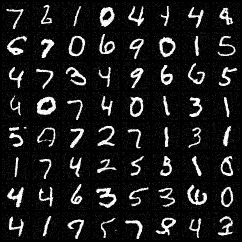

In [14]:
display(Image('samples/ep_50_half_ddpm.png'))

In [15]:
assert os.path.exists('checkpoints/ep_50_half_ddpm.pth')
!cp checkpoints/ep_50_half_ddpm.pth backup/ep_50_half_ddpm.pth

# Reduce size of DDPM

In [8]:
from vanilla_unet import UNet

In [10]:
# old num parameters
print('full DDPM:',sum(p.numel() for p in UNet().parameters()))
print('reduced DDPM:',sum(p.numel() for p in UNet(nf=64).parameters()))

full DDPM: 6065665
reduced DDPM: 1521409


In [11]:
model = UNet(nf=64).cuda()
model = nn.DataParallel(model)
preparer = DDPM_BatchPrep(max_T=T//2)
sampler = DDPM_Sampler(max_T=T//2)
trainer = DDPM_trainer(model, preparer=preparer, sampler=sampler, epochs=50, lr=1e-4, sample_ep=4, desc='half_ddpm_small')
trainer.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.45it/s]


Epoch 1, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.37it/s]


Epoch 4, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.49it/s]


Epoch 8, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.30it/s]


Epoch 12, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.54it/s]


Epoch 16, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.88it/s]


Epoch 20, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.46it/s]


Epoch 24, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.40it/s]


Epoch 28, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.35it/s]


Epoch 32, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 104.73it/s]


Epoch 36, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.13it/s]


Epoch 40, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.84it/s]


Epoch 44, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.28it/s]


Epoch 48, sample saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.30it/s]

Epoch 50, sample saved


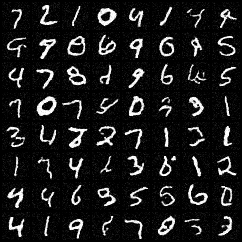

In [12]:
display(Image('samples/ep_50_half_ddpm_small.png'))

In [13]:
assert os.path.exists('checkpoints/ep_50_half_ddpm_small.pth')
!cp checkpoints/ep_50_half_ddpm_small.pth backup/ep_50_half_ddpm_small.pth

# Full Flow Matching (Baseline)

In [ ]:
assert False